In [7]:
import os
import glob
import shutil
import cv2
import tifffile
import numpy as np

# ----------------------------------------------------------------
# CONFIGURATION
# ----------------------------------------------------------------
PATCH_SIZE = 256
STRIDE = PATCH_SIZE

# --- Input (original) dataset ---
ORIG_IMG_DIR = "/Users/celinewu/Documents/2023_dataset/images"  # Update with your image directory
ORIG_MASK_DIR = "/Users/celinewu/Documents/2023_dataset/masks"  # Update with your mask directory

# --- Output (processed) dataset ---
OUT_IMG_DIR = "/Users/celinewu/Documents/2023DS/images"    # Update output image directory
OUT_MASK_DIR = "/Users/celinewu/Documents/2023DS/masks"    # Update output mask directory

os.makedirs(os.path.join(OUT_MASK_DIR, "train"), exist_ok=True)
os.makedirs(os.path.join(OUT_MASK_DIR, "test"), exist_ok=True)

def get_corresponding_masks(img_name, mask_dir):
    """
    Get corresponding mask file paths for a given image name.
    This function excludes any masks with 'occluded' in the name.
    """
    base_name = os.path.splitext(img_name)[0]  # Strip extension
    mask_candidates = glob.glob(os.path.join(mask_dir, f"{base_name}*"))
    
    masks = {
        "root": None,
        "shoot": None,
        "seed": None,
    }
    
    for mask_path in mask_candidates:
        if "occluded" in mask_path:
            continue
        if "_root_mask" in mask_path:
            masks["root"] = mask_path
        elif "_shoot_mask" in mask_path:
            masks["shoot"] = mask_path
        elif "_seed_mask" in mask_path:
            masks["seed"] = mask_path
    
    return masks

def process_split(split_name):
    """
    Process a specific split (train/test) to copy corresponding masks.
    """
    print(f"Processing {split_name} split...")
    
    img_dir = os.path.join(ORIG_IMG_DIR, split_name)
    mask_out_dir = os.path.join(OUT_MASK_DIR, split_name)
    
    # Get all image files in the split
    img_files = glob.glob(os.path.join(img_dir, "*.png"))  # Assuming PNG images
    
    for img_file in img_files:
        img_name = os.path.basename(img_file)
        masks = get_corresponding_masks(img_name, ORIG_MASK_DIR)
        
        for mask_type, mask_path in masks.items():
            if mask_path:
                mask_out_path = os.path.join(mask_out_dir, os.path.basename(mask_path))
                shutil.copy(mask_path, mask_out_path)
    
    print(f"Completed processing {split_name} split.")

def process_dataset():
    """
    Process the entire dataset (train and test splits).
    """
    for split in ["train", "test"]:
        process_split(split)
    print("All done!")

if __name__ == "__main__":
    process_dataset()


Processing train split...
Completed processing train split.
Processing test split...
Completed processing test split.
All done!


In [10]:
import os
IMG_DIR = "/Users/celinewu/Documents/2023_dataset/images"
print(os.listdir(IMG_DIR))

['.DS_Store', 'test', 'train']


In [11]:
import os
import glob
import cv2
import tifffile
import numpy as np

# ----------------------------------------------------------------
# CONFIGURATION
# ----------------------------------------------------------------
PATCH_SIZE = 256
STRIDE = PATCH_SIZE

# --- Input (original) dataset ---
ORIG_DATA_DIR = "/Users/celinewu/Documents/2023_dataset"
IMG_DIR = os.path.join(ORIG_DATA_DIR, "images")
MASK_DIR = os.path.join(ORIG_DATA_DIR, "masks")

# --- Output (processed) dataset ---
OUT_DATA_DIR = "/Users/celinewu/Documents/2023DS"

# Subfolders for images
OUT_IMG_TRAIN = os.path.join(OUT_DATA_DIR, "images", "train")
OUT_IMG_TEST = os.path.join(OUT_DATA_DIR, "images", "test")

# Subfolders for masks
OUT_MASK_TRAIN = os.path.join(OUT_DATA_DIR, "masks", "train")
OUT_MASK_TEST = os.path.join(OUT_DATA_DIR, "masks", "test")

os.makedirs(OUT_IMG_TRAIN, exist_ok=True)
os.makedirs(OUT_IMG_TEST, exist_ok=True)
os.makedirs(OUT_MASK_TRAIN, exist_ok=True)
os.makedirs(OUT_MASK_TEST, exist_ok=True)

def pad_to_multiple(img, multiple=256, border_mode=cv2.BORDER_REFLECT):
    h, w = img.shape[:2]
    pad_h = (multiple - (h % multiple)) if (h % multiple) != 0 else 0
    pad_w = (multiple - (w % multiple)) if (w % multiple) != 0 else 0
    return cv2.copyMakeBorder(img, 0, pad_h, 0, pad_w, border_mode)

def split_into_patches(img, patch_size=256, stride=256):
    h, w = img.shape[:2]
    patches = []
    for y in range(0, h, stride):
        for x in range(0, w, stride):
            patch = img[y:y+patch_size, x:x+patch_size]
            patches.append(patch)
    return patches

def process_split(split_name):
    split_img_dir = os.path.join(IMG_DIR, split_name)
    split_mask_dir = os.path.join(MASK_DIR, split_name)
    out_img_folder = OUT_IMG_TRAIN if split_name == "train" else OUT_IMG_TEST
    out_mask_folder = OUT_MASK_TRAIN if split_name == "train" else OUT_MASK_TEST

    image_paths = glob.glob(os.path.join(split_img_dir, "*.png"))
    if not image_paths:
        print(f"No images found in {split_img_dir}")
        return

    print(f"Processing {len(image_paths)} images in {split_name} split...")
    for img_path in image_paths:
        base_name = os.path.basename(img_path)
        file_no_ext = os.path.splitext(base_name)[0]

        # Build mask paths
        root_path = os.path.join(split_mask_dir, f"{file_no_ext}_root_mask.tif")
        shoot_path = os.path.join(split_mask_dir, f"{file_no_ext}_shoot_mask.tif")
        seed_path = os.path.join(split_mask_dir, f"{file_no_ext}_seed_mask.tif")

        img_bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img_bgr is None:
            print(f"[ERROR] Cannot read image: {img_path}")
            continue

        # Read the masks if they exist
        mask_root = tifffile.imread(root_path) if os.path.exists(root_path) else None
        mask_shoot = tifffile.imread(shoot_path) if os.path.exists(shoot_path) else None
        mask_seed = tifffile.imread(seed_path) if os.path.exists(seed_path) else None

        padded_img = pad_to_multiple(img_bgr, PATCH_SIZE, cv2.BORDER_REFLECT)
        padded_root = pad_to_multiple(mask_root, PATCH_SIZE, cv2.BORDER_REFLECT) if mask_root is not None else None
        padded_shoot = pad_to_multiple(mask_shoot, PATCH_SIZE, cv2.BORDER_REFLECT) if mask_shoot is not None else None
        padded_seed = pad_to_multiple(mask_seed, PATCH_SIZE, cv2.BORDER_REFLECT) if mask_seed is not None else None

        img_patches = split_into_patches(padded_img, PATCH_SIZE, STRIDE)
        root_patches = split_into_patches(padded_root, PATCH_SIZE, STRIDE) if padded_root is not None else [None] * len(img_patches)
        shoot_patches = split_into_patches(padded_shoot, PATCH_SIZE, STRIDE) if padded_shoot is not None else [None] * len(img_patches)
        seed_patches = split_into_patches(padded_seed, PATCH_SIZE, STRIDE) if padded_seed is not None else [None] * len(img_patches)

        for idx, img_patch in enumerate(img_patches):
            patch_name_img = f"{file_no_ext}_{idx}.png"
            patch_name_root = f"{file_no_ext}_root_mask_{idx}.tif"
            patch_name_shoot = f"{file_no_ext}_shoot_mask_{idx}.tif"
            patch_name_seed = f"{file_no_ext}_seed_mask_{idx}.tif"

            cv2.imwrite(os.path.join(out_img_folder, patch_name_img), img_patch)

            if root_patches[idx] is not None:
                tifffile.imwrite(os.path.join(out_mask_folder, patch_name_root), root_patches[idx])
            if shoot_patches[idx] is not None:
                tifffile.imwrite(os.path.join(out_mask_folder, patch_name_shoot), shoot_patches[idx])
            if seed_patches[idx] is not None:
                tifffile.imwrite(os.path.join(out_mask_folder, patch_name_seed), seed_patches[idx])

def process_dataset():
    for split in ["train", "test"]:
        process_split(split)
    print("Processing complete!")

if __name__ == "__main__":
    process_dataset()


Processing 96 images in train split...
Processing 30 images in test split...
Processing complete!


In [12]:
import os
import glob

def remove_images_with_no_masks(images_dir, masks_dir):
    """
    For each *.png in 'images_dir', checks if the corresponding
    root/shoot/seed *.tif files exist in 'masks_dir'.
    If *all three* are missing, deletes the image file.
    """
    image_paths = glob.glob(os.path.join(images_dir, "*.png"))
    print(f"Checking {len(image_paths)} patches in '{images_dir}'...")

    for image_path in image_paths:
        image_name = os.path.basename(image_path)
        base_name = os.path.splitext(image_name)[0]
        # Example: base_name = "train_Alican_230858_im3_0"

        # Split off the last underscore to get prefix/suffix
        # e.g. prefix="train_Alican_230858_im3", suffix="0"
        idx = base_name.rfind("_")
        prefix = base_name[:idx]
        suffix = base_name[idx+1:]

        # Construct the expected mask filenames
        root_mask_path = os.path.join(masks_dir, f"{prefix}_root_mask_{suffix}.tif")
        shoot_mask_path = os.path.join(masks_dir, f"{prefix}_shoot_mask_{suffix}.tif")
        seed_mask_path = os.path.join(masks_dir, f"{prefix}_seed_mask_{suffix}.tif")

        # Check if any of these files exist
        root_exists  = os.path.exists(root_mask_path)
        shoot_exists = os.path.exists(shoot_mask_path)
        seed_exists  = os.path.exists(seed_mask_path)

        # If all three are missing, remove the image patch
        if not (root_exists or shoot_exists or seed_exists):
            print(f"  Deleting {image_name} because no mask files were found.")
            os.remove(image_path)

# ----------------------------------------------------------------
# Run for both "train" and "test" folders
# ----------------------------------------------------------------
processed_ds = "/Users/celinewu/Documents/2023DS"

train_img_dir = os.path.join(processed_ds, "images", "train")
train_mask_dir = os.path.join(processed_ds, "masks", "train")

test_img_dir = os.path.join(processed_ds, "images", "test")
test_mask_dir = os.path.join(processed_ds, "masks", "test")

# Remove unmatched image patches in train
remove_images_with_no_masks(train_img_dir, train_mask_dir)
# Remove unmatched image patches in test
remove_images_with_no_masks(test_img_dir, test_mask_dir)

print("Done cleaning up image patches without corresponding masks.")


Checking 19584 patches in '/Users/celinewu/Documents/2023DS/images/train'...
  Deleting 023_43-18-ROOT1-2023-08-08_pvd_OD001_f6h1_01-Fish Eye Corrected_108.png because no mask files were found.
  Deleting 023_43-14-ROOT1-2023-08-08_pvdCherry_OD0001_f6h1_03-Fish Eye Corrected_76.png because no mask files were found.
  Deleting 023_43-14-ROOT1-2023-08-08_pvdCherry_OD0001_f6h1_03-Fish Eye Corrected_62.png because no mask files were found.
  Deleting 019_43-19-ROOT1-2023-08-08_pvd_OD001_Col0_03-Fish Eye Corrected_78.png because no mask files were found.
  Deleting 000_43-2-ROOT1-2023-08-08_pvd_OD0001_f6h1_02-Fish Eye Corrected_63.png because no mask files were found.
  Deleting 023_43-18-ROOT1-2023-08-08_pvd_OD001_f6h1_01-Fish Eye Corrected_134.png because no mask files were found.
  Deleting 019_43-19-ROOT1-2023-08-08_pvd_OD001_Col0_03-Fish Eye Corrected_50.png because no mask files were found.
  Deleting 019_43-19-ROOT1-2023-08-08_pvd_OD001_Col0_03-Fish Eye Corrected_44.png because no ma

In [13]:
import random
import os
import cv2
import tifffile
import matplotlib.pyplot as plt

TRAIN_IMG_DIR = "/Users/celinewu/Documents/2023DS/images/train"
TRAIN_MASK_DIR = "/Users/celinewu/Documents/2023DS/masks/train"

# list all image patches
image_patches = os.listdir(TRAIN_IMG_DIR)
if not image_patches:
    print("No train patches found.")
else:
    rand_patch_name = random.choice(image_patches)  # e.g. train_Alican_230858_im3_0.png
    print("Random image patch:", rand_patch_name)
    
    # load image
    img_path = os.path.join(TRAIN_IMG_DIR, rand_patch_name)
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # try root mask
    base_no_ext = os.path.splitext(rand_patch_name)[0]  # e.g. train_Alican_230858_im3_0
    root_mask_name  = base_no_ext + "_root_mask.tif"
    root_mask_path  = os.path.join(TRAIN_MASK_DIR, root_mask_name)
    if os.path.exists(root_mask_path):
        root_mask = tifffile.imread(root_mask_path)
        overlay = img_rgb.copy()
        overlay[root_mask > 0] = [255, 0, 0]  # highlight in red
        blended = cv2.addWeighted(img_rgb, 0.6, overlay, 0.4, 0)
        
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(img_rgb)
        axs[0].set_title("Image Patch")
        axs[1].imshow(root_mask, cmap='gray')
        axs[1].set_title("Root Mask")
        axs[2].imshow(blended)
        axs[2].set_title("Overlay (root in red)")
        for ax in axs:
            ax.axis('off')
        plt.show()
    else:
        print("No root mask found for this patch.")


Random image patch: 013_43-6-ROOT1-2023-08-08_pvd_OD001_f6h1_01-Fish Eye Corrected_72.png
No root mask found for this patch.


Random image patch: 024_43-18-ROOT1-2023-08-08_pvd_OD0001_f6h1_02-Fish Eye Corrected_141.png
Looking for root mask at: /Users/celinewu/Documents/2023DS/masks/train/024_43-18-ROOT1-2023-08-08_pvd_OD0001_f6h1_02-Fish Eye Corrected_root_mask_141.tif
Looking for shoot mask at: /Users/celinewu/Documents/2023DS/masks/train/024_43-18-ROOT1-2023-08-08_pvd_OD0001_f6h1_02-Fish Eye Corrected_shoot_mask_141.tif
Looking for seed mask at: /Users/celinewu/Documents/2023DS/masks/train/024_43-18-ROOT1-2023-08-08_pvd_OD0001_f6h1_02-Fish Eye Corrected_seed_mask_141.tif


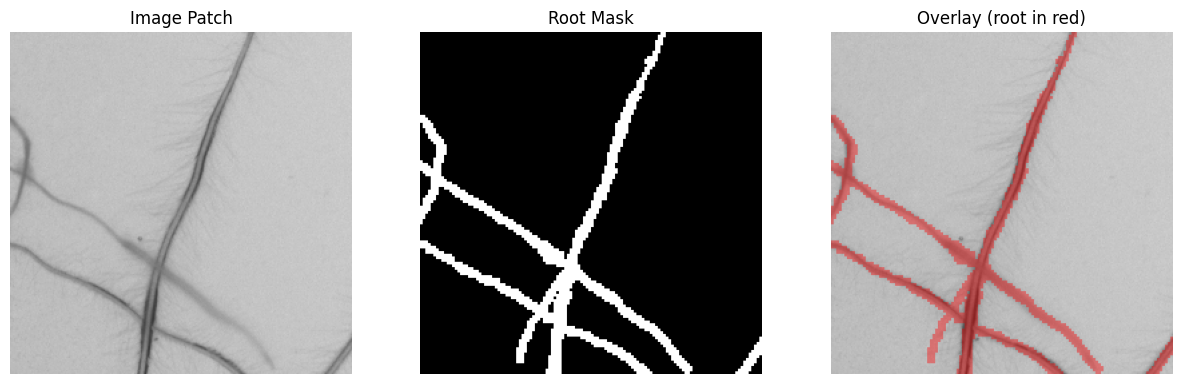

In [21]:
import random
import os
import cv2
import tifffile
import matplotlib.pyplot as plt

TRAIN_IMG_DIR = "/Users/celinewu/Documents/2023DS/images/train"
TRAIN_MASK_DIR = "/Users/celinewu/Documents/2023DS/masks/train"

# List all image patches
image_patches = os.listdir(TRAIN_IMG_DIR)
if not image_patches:
    print("No train patches found.")
else:
    rand_patch_name = random.choice(image_patches)  # e.g. train_Dean_231667_im1_23.png
    print("Random image patch:", rand_patch_name)
    
    # Load image
    img_path = os.path.join(TRAIN_IMG_DIR, rand_patch_name)
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Construct mask filenames based on the correct naming convention
    base_no_ext = os.path.splitext(rand_patch_name)[0]  # e.g. train_Dean_231667_im1_23
    base_parts = base_no_ext.rsplit("_", 1)  # Split into ["train_Dean_231667_im1", "23"]
    mask_base = base_parts[0]  # "train_Dean_231667_im1"
    patch_index = base_parts[1]  # "23"
    
    # Construct mask filenames
    root_mask_name  = f"{mask_base}_root_mask_{patch_index}.tif"
    shoot_mask_name = f"{mask_base}_shoot_mask_{patch_index}.tif"
    seed_mask_name  = f"{mask_base}_seed_mask_{patch_index}.tif"
    
    root_mask_path  = os.path.join(TRAIN_MASK_DIR, root_mask_name)
    shoot_mask_path = os.path.join(TRAIN_MASK_DIR, shoot_mask_name)
    seed_mask_path  = os.path.join(TRAIN_MASK_DIR, seed_mask_name)
    
    # Debugging paths
    print("Looking for root mask at:", root_mask_path)
    print("Looking for shoot mask at:", shoot_mask_path)
    print("Looking for seed mask at:", seed_mask_path)
    
    # Check if root mask exists and display
    if os.path.exists(root_mask_path):
        root_mask = tifffile.imread(root_mask_path)
        overlay = img_rgb.copy()
        overlay[root_mask > 0] = [255, 0, 0]  # Highlight root mask in red
        blended = cv2.addWeighted(img_rgb, 0.6, overlay, 0.4, 0)
        
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(img_rgb)
        axs[0].set_title("Image Patch")
        axs[1].imshow(root_mask, cmap='gray')
        axs[1].set_title("Root Mask")
        axs[2].imshow(blended)
        axs[2].set_title("Overlay (root in red)")
        for ax in axs:
            ax.axis('off')
        plt.show()
    else:
        print(f"No root mask found for this patch: {rand_patch_name}")
